In [1]:
%matplotlib inline

# Bikeshare Ridership 

Notebook to predict the number of trips per day for Capital Bikeshare in Washington, DC based on the season of year and the given weather.  Data built from two years of trip data (2011 and 2012) from Capital Bikeshare.

### Notebook Setup

In [3]:
import os 
import sys 

sys.path.append("/Users/benjamin/Repos/ddl/yellowbrick")
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

sns.set_context('notebook')
sns.set_style('whitegrid')

## Data Loading

In [5]:
data = pd.read_csv('data/hour.csv')
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61
17378,17379,2012-12-31,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49


## Exploratory

In [11]:
# Stats for trips data
trips_cols = ['casual', 'registered', 'cnt']
data[trips_cols].describe()

,casual,registered,cnt
count,17379.000000,17379.000000,17379.000000
mean,35.676218,153.786869,189.463088
std,49.305030,151.357286,181.387599
min,0.000000,0.000000,1.000000
25%,4.000000,34.000000,40.000000
50%,17.000000,115.000000,142.000000
75%,48.000000,220.000000,281.000000
max,367.000000,886.000000,977.000000


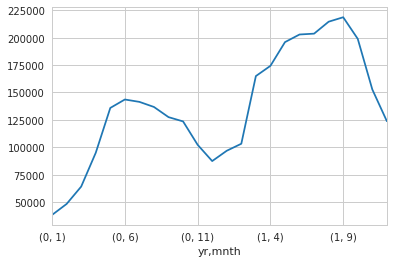

In [46]:
# Plot of trips over time to show seasonality and need to split training data by time of year
trips_df = data[['cnt', 'yr', 'mnth']].groupby(['yr', 'mnth'])['cnt'].sum()
trips_df.plot(kind='line')


### Plot Analysis
We can see in the plot above that there are two factors at play
* Seasonality - Trips peak in the spring/summer and curtail significantly in the winter
* System Growth - Capital Bikeshare started a few months prior to the data provided, so when you look at trips by month from year 0 to year 1, you ssee significant growth

Therefore, we should be splitting the data by time chunked, using all data through Fall of Year 1 as the train, and Winter of Year 1 as the test

In [73]:
# Count of records in winter of year 1, should be used to determine max train size, full dataset is 17,379 instances
total_records = data.shape[0]
winter_yr1_records = data[(data['yr'] == 1) & (data['season']== 4)].shape[0]
max_train_size = total_records - winter_yr1_records
print("All Records:{}, Test Records:{}, Max Train Records:{}".format(total_records, winter_yr1_records, max_train_size))

All Records:17379, Test Records:2098, Max Train Records:15281


In [101]:
from sklearn.model_selection import TimeSeriesSplit as tss
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
# https://www.packtpub.com/mapt/book/big_data_and_business_intelligence/9781787286382/7/ch07lvl1sec71/time-series-cross-validation
features = [
    'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 
    'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 
]

target = 'cnt' # can be one of 'casual', 'registered', 'cnt'

X = data[features]
y = data[target]


X_train, X_test, y_train, y_test = X[:max_train_size], X[max_train_size:], y[:max_train_size], y[max_train_size:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(15281, 12)
(2098, 12)
(15281,)
(2098,)


## Do Some Regression 

In [102]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score 

In [103]:
# OLS 
from sklearn.linear_model import LinearRegression 

model = LinearRegression() 
model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f}".format(r2,me))

r2=0.296 MSE=28160.167


In [104]:
# L2 and L1 Regularization 
alphas = np.logspace(-10, 0, 200)

In [105]:
from sklearn.linear_model import RidgeCV 

model = RidgeCV(alphas=alphas) 
model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f} alpha={:0.3f}".format(r2,me, model.alpha_))

r2=0.296 MSE=28167.260 alpha=1.000


In [106]:
from sklearn.linear_model import LassoCV 

model = LassoCV(alphas=alphas) 
model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f} alpha={:0.3f}".format(r2,me, model.alpha_))

r2=0.295 MSE=28197.880 alpha=0.062


In [107]:
from sklearn.linear_model import ElasticNetCV

model = ElasticNetCV(alphas=alphas) 
model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f}".format(r2,me))

r2=0.293 MSE=28307.830


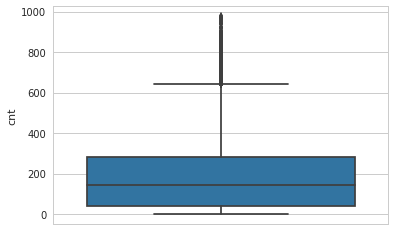

In [108]:
sns.boxplot(y=target, data=data)

In [109]:
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.pipeline import Pipeline 

model = Pipeline([
    ('poly', PolynomialFeatures(2)), 
    ('lasso', LassoCV(alphas=alphas)),
])

model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f} alpha={:0.3f}".format(r2,me, model.named_steps['lasso'].alpha_))

/home/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


r2=0.418 MSE=23283.559 alpha=1.000


In [113]:
model = Pipeline([
    ('poly', PolynomialFeatures(2)), 
    ('ridge', RidgeCV(alphas=alphas)),
])

model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f} alpha={:0.3f}".format(r2,me, model.named_steps['ridge'].alpha_))

r2=0.481 MSE=20777.495 alpha=0.031


In [111]:
model = Pipeline([
    ('poly', PolynomialFeatures(3)), 
    ('ridge', RidgeCV(alphas=alphas)),
])

model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f} alpha={:0.3f}".format(r2,me, model.named_steps['ridge'].alpha_))

r2=-1.294 MSE=91819.449 alpha=0.022


In [112]:
model = Pipeline([
    ('poly', PolynomialFeatures(4)), 
    ('ridge', RidgeCV(alphas=alphas)),
])

model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f} alpha={:0.3f}".format(r2,me, model.named_steps['ridge'].alpha_))

r2=-6.050 MSE=282121.433 alpha=0.222


In [114]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor() 
model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f}".format(r2,me))

r2=0.857 MSE=5704.677


## Save the Forests!

In [23]:
import pickle 

with open('forest-riders.pkl', 'wb') as f:
    pickle.dump(model, f)

In [24]:
with open('forest-riders.pkl', 'rb') as f:
    model = pickle.load(f)

In [25]:
model.predict(X_test)

array([ 161.7,  211.5,  243.6, ...,    2.6,  233.9,  234.9])

In [18]:
from sklearn.ensemble import AdaBoostRegressor

model = AdaBoostRegressor() 
model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f}".format(r2,me))

r2=0.681 MSE=7251.873


In [19]:
from sklearn.linear_model import BayesianRidge

model = BayesianRidge() 
model.fit(X_train, y_train)

yhat = model.predict(X_test)

r2 = r2_score(y_test, yhat)
me = mse(y_test, yhat)

print("r2={:0.3f} MSE={:0.3f}".format(r2,me))

r2=0.339 MSE=15025.645


In [21]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(5)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.91569589942537322